# CS 236 Project Phase 1: Data Cleaning and EDA

## Installation

We installed the required dependencies using pip.

```
pip install pyspark pandas plotly nbformat matplotlib
```

We couldn't get PySpark 3 to work on our machines, so we used the latest PySpark 4 instead.
We also had some issues with the Java version - Java 25 is not supported, so we used Java 21.

## Customer Reservations Analysis

In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly

from pyspark.sql import functions as F

In [227]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, when, col, count, expr, lit, desc
from pyspark.sql.types import IntegerType

spark = SparkSession.builder.getOrCreate()

hotel_booking = spark.read.csv(
    "datasets/hotel-booking.csv",
    header=True,
    inferSchema=True,
)
customer_reservations = spark.read.csv(
    "datasets/customer-reservations.csv",
    header=True,
    inferSchema=True,
)

hotel_booking.printSchema()
customer_reservations.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- country: string (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- email: string (nullable = true)

root
 |-- Booking_ID: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_date: integer (nullable = true)
 |-- market_segment_type: string (nullable 

We can do some exploratory data analysis to see what these datasets are like. For instance, we can see which are the most popular months are.

In [228]:
customer_reservations.groupBy("arrival_month").agg(count("*").alias("count")).sort(
    "arrival_month"
).plot.line(x="arrival_month", y="count")

We can also see what the lead times of customers are.

In [229]:
customer_reservations.select("lead_time").plot.hist(column="lead_time")

From the above, we can see that it heavily skewed, showing that most people book close to the date they are planning to stay.

Here we can see what the most popular market segments are. We find that there are five segments, with online being the most popular, offline being the next most, and the rest far below.

In [230]:
customer_reservations.groupBy("market_segment_type").agg(
    count("*").alias("count")
).orderBy(desc("count")).plot.bar(x="market_segment_type", y="count")

## Data Cleaning and EDA for Hotel Booking Dataset

### Cleaning

Before we continue with the EDA it is important to clean out any NaN's or null values from the data and any duplicates data points.

In [231]:
# filter by drop na datapoints and dropping duplicate rows
hotel_booking = hotel_booking.dropna().dropDuplicates()

### EDA

In the EDA for the hotel_booking dataset, we're trying to see how many rows and columns the csv file has along with the summary statistics and distribution for each column (individually). There are 13 columns and 78703 rows (78297 rows after cleaning).

For categorical variables, we're interested in seeing how many categories there are and the frequency of each. This will be done with a frequency table and a bar chart.

For numerical variables, we're interested in seeing the distribution. This will be done by plotting a histogram and printing some summary statistics.

At a first glance, there are some columns that seem to mesh together because they record similar events.
1. Arrival year, month, day, and week number
2. stays_in_week_nights and stays_in_weekend_nights

In [232]:
# dimensionality of data
num_rows = hotel_booking.count()
num_cols = len(hotel_booking.columns)

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_cols}")

Number of Rows: 78297
Number of Columns: 13


#### Hotel Column

In [233]:
# frequency for hotel column
hotel_counts = hotel_booking.groupBy("hotel").agg(F.count("*").alias("count"))

hotel_counts.plot.bar(x="hotel", y="count")

The City Hotel received a lot more bookings (≈52,000) than the Resort Hotel (≈27,000). Used a bar chart here because we're counting the frequencies of categories.

#### Booking Status Column

In [234]:
# frequency for booking status column
booking_status_counts = hotel_booking.groupBy("booking_status").agg(
    F.count("*").alias("count")
)

booking_status_counts.plot.bar(x="booking_status", y="count")

There were more bookings with status 0 (≈50,000) than 1 (≈29,000), indicating that a larger share of bookings were not completed or canceled, while fewer were successful or confirmed. Used a bar chart here because we're counting the frequencies of two categories (0 and 1).

#### Lead Time Column

In [235]:
# histogram of lead time
lead_time_pd = hotel_booking.select("lead_time")
lead_time_pd.plot.hist(column="lead_time")

In [236]:
# summary statistics
lead_time_pd.describe().show()

+-------+------------------+
|summary|         lead_time|
+-------+------------------+
|  count|             78297|
|   mean|101.63688263918158|
| stddev|106.25412794740647|
|    min|                 0|
|    max|               737|
+-------+------------------+



The lead time column is numerical and skewed to the right. This is seen in both the histogram of the column's values and in its summary statistics (mean is greater than median with the maximum being far from the 3rd quartile).

Here we used a histogram to plot the data because the column is numerical. I wanted to see the distribution of said numerical datapoints.

#### Arrival Date Columns

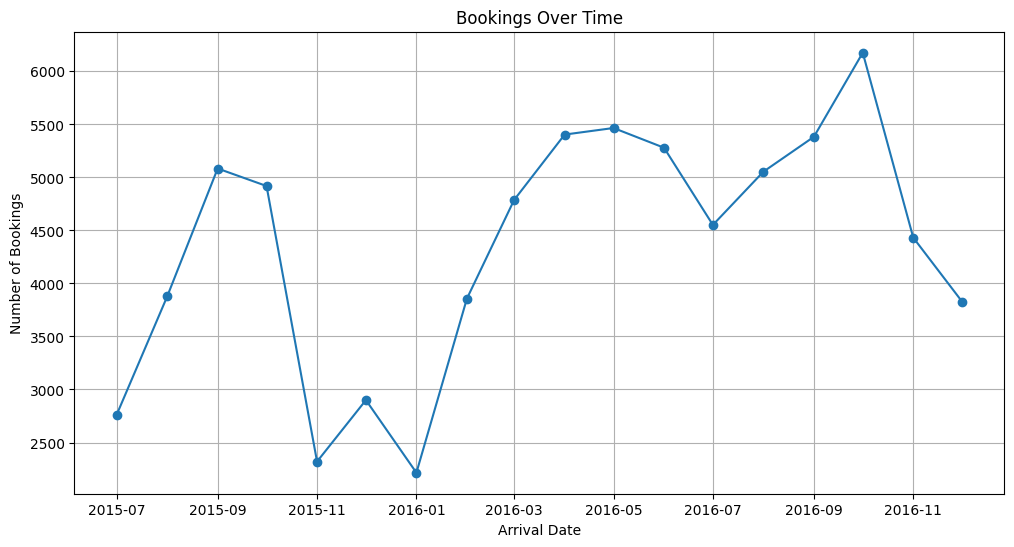

In [237]:
# Date time column
arrival_date_counts = (
    hotel_booking.groupBy("arrival_year", "arrival_month")
    .agg(F.count("*").alias("count"))
    .orderBy("arrival_year", "arrival_month")  # sort by year and month
).toPandas()

arrival_date_counts["arrival_date"] = pd.to_datetime(
    arrival_date_counts["arrival_year"].astype(str)
    + "-"
    + arrival_date_counts["arrival_month"].astype(str)
    + "-01"
)

# Sort by datetime
arrival_date_counts = arrival_date_counts.sort_values("arrival_date")

# time series plot of number of bookings each month
plt.figure(figsize=(12, 6))
plt.plot(arrival_date_counts["arrival_date"], arrival_date_counts["count"], marker="o")
plt.xlabel("Arrival Date")
plt.ylabel("Number of Bookings")
plt.title("Bookings Over Time")
plt.grid(True)
plt.show()

At first glance, the number of bookings per month over time looking sporadic. The most noticable features are a sharp increase in bookings from 07/2015 to 09/2015 and a sharp decline and increase from 10/2015 to 03/2016.

Used a time series here because the data is here is time related (year, month). It helps plot the amount of bookings in each month listed in the data set. With a time series, we can observe how booking volumes fluctuate across months and years, revealing possible seasonal peaks or drops.

#### Weekday and Weekend Staying Columns

In [238]:
# histogram for stays in weekend nights
weekends_pd = hotel_booking.select("stays_in_weekend_nights")
weekends_pd.plot.hist(column="stays_in_weekend_nights")

In [239]:
# summary statistics
weekends_pd.describe().show()

+-------+-----------------------+
|summary|stays_in_weekend_nights|
+-------+-----------------------+
|  count|                  78297|
|   mean|     0.9052837273458754|
| stddev|     0.9857183925894243|
|    min|                      0|
|    max|                     16|
+-------+-----------------------+



In [240]:
# histogram for stays in week nights
weekdays_pd = hotel_booking.select("stays_in_week_nights")
weekdays_pd.plot.hist(column="stays_in_week_nights")

In [241]:
# summary statistics
weekdays_pd.describe().show()

+-------+--------------------+
|summary|stays_in_week_nights|
+-------+--------------------+
|  count|               78297|
|   mean|   2.449302016680077|
| stddev|  1.8584755287431443|
|    min|                   0|
|    max|                  41|
+-------+--------------------+



Both columns recording days stays are skewed to the right. The majority of hotel bookings are for a short period of time(~2 days) with some very high data points (>10 days) skewing the data.

Both of these columns were numerical, so the histogram was the way to go to see the distribution of said columns.

#### Market Segment Type Column

In [242]:
# frequency for market column
market_counts = (
    hotel_booking.groupBy("market_segment_type")
    .agg(F.count("*").alias("count"))
    .orderBy(F.desc("count"))
)
market_counts.plot.bar(x="market_segment_type", y="count")

Looking at the frequency of each market type, we can see that "Online TA" takes up a huge portion of the data. Offline TA/TO and Groups follows behind. Direct and Corporate take up a meager portion of the data points. Complemntary, Aviation, and Undefined barely make up the datapoints.

For an EDA here, we want to count the frequencies for each market type in the data. Since the market type variable is categorical, a bar chart was a good choice.

#### Country Column

In [243]:
# frequency for market column
country_counts = market_counts = (
    hotel_booking.groupBy("country")
    .agg(F.count("*").alias("count"))
    .orderBy(F.desc("count"))
    .limit(10)
)
country_counts.plot.bar(x="country", y="count")

Looking at the top 10 countries our data is coming from, we can see that PRT (Portugal) takes up a huge portion of the data points. With GBR, FRA, ESP, and DEU tailing behind each with frequencies from 4k to 7k. The remaining 5 countries in the top 5 all have frequencies around 1k-2k.

For an EDA here, we want to count the frequencies for each country in the data. Since the country variable is categorical, a bar chart was a good choice.

#### Average Price Column

In [244]:
# histogram of price
price_pd = hotel_booking.select("avg_price_per_room")
price_pd.plot.hist(column="avg_price_per_room")

In [245]:
# boxplot of price
price_pd.plot.box(column="avg_price_per_room")

In [246]:
# summary statistics of price
price_pd.describe().show()

+-------+------------------+
|summary|avg_price_per_room|
+-------+------------------+
|  count|             78297|
|   mean| 95.37531667880025|
| stddev| 48.25922636213088|
|    min|               0.0|
|    max|            5400.0|
+-------+------------------+



Most of the data points have average price somewhere below 1k. We can't really view the distribution of this bar because of some really high outliers. To proceed, we're going to only plot points that are not outliers (IQR) to view the distribution of the majority of points.

In [247]:
# bounds to filter outliers
quantiles = hotel_booking.approxQuantile("avg_price_per_room", [0.25, 0.75], 0.01)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

filtered_prices = hotel_booking.filter(
    (F.col("avg_price_per_room") >= lower_bound)
    & (F.col("avg_price_per_room") <= upper_bound)
).select("avg_price_per_room")

filtered_prices.plot.hist(column="avg_price_per_room")

In [248]:
# boxplot of prices w/o big outliers
filtered_prices.plot.box(column="avg_price_per_room")

In [249]:
# summary statistics w/o big outliers
filtered_prices.describe().show()

+-------+------------------+
|summary|avg_price_per_room|
+-------+------------------+
|  count|             75578|
|   mean| 90.62128582391728|
| stddev|  37.0610516188572|
|    min|               0.0|
|    max|            192.73|
+-------+------------------+



Comparing the counts of the unfiltered and filtered data, we can see that there are some data points with very high prices. After removing these outliers, we see that the majority of the average price data is between 0 and 200. The histogram slightly resembles a normal distribution.

The price column is numerical which makes histograms a good choice. Except in this case, it was not a good choice because of how big some outliers were. It really messed up the bins in the plotted histogram. In a case like this, a boxplot is a much better choice since it uses median and quartiles. With a boxplot, we could view statistics but the majority of the data was concentrated into a very small region.

We filtered the data to remove those really large outliers (plus minus 1.5 IQR from Q1 and Q3) so we could see the distribution of the majority of the datapoints. A boxplot was good for showing the quartiles and median of the filtered data while a histogram did a great job at showing the data's shape and distribution.

### Hotel Booking EDA Findings and Conclusion

The dataset contains **78,703** rows and **13** columns.

Each column was analyzed individually to understand its distribution and frequency.

- Categorical variables were explored using frequency tables and bar charts to show the number of categories and their frequencies.
- Numerical variables were examined using histograms and summary statistics to show their distributions and central tendencies.

**Key Observations:**

**1. Hotel Type:**
The City Hotel received significantly more bookings (≈52,000) than the Resort Hotel (≈27,000).

**2. Booking Status:**
There were more bookings with status 0 (≈50,000) than 1 (≈29,000), indicating a larger share of bookings were not completed or canceled.

**3. Lead Time:**
The lead_time variable is right-skewed. The mean is greater than the median, and the maximum value is far above the third quartile.

**4. Arrival Information:**
The columns arrival_year, arrival_month, arrival_day, and arrival_week_number record similar events and could potentially be combined for analysis.
The number of bookings per month over time appears sporadic, with a sharp increase from July 2015 to September 2015, followed by a decline and subsequent fluctuations between October 2015 and March 2016.

**5. Stay Duration:**
Both stays_in_week_nights and stays_in_weekend_nights are right-skewed. Most bookings are short (around 2 days), with a few very long stays (>10 days) creating skew.

**6. Market Type:**
The market_segment_type column is dominated by Online TA, followed by Offline TA/TO and Groups.
Direct and Corporate segments are small, while Complementary, Aviation, and Undefined categories appear rarely.

**7. Country:**
The top 10 countries show that Portugal (PRT) has the most bookings by far.
GBR, FRA, ESP, and DEU follow with 4k–7k bookings each, while the remaining top countries range between 1k–2k bookings.

**8. Average Price:**
Most average prices are below 1,000, but the distribution is heavily affected by extreme outliers.
After removing outliers using the IQR method (around 2,000 data points removed), the majority of avg_price_per_room values fall between 0 and 200, forming a roughly normal-shaped distribution.

## Filtering and Merging the 2 Datasets

Initially, we thought we would have to do a join operation across the 2 datasets along the dates given what we were learning in class last week. However, looking at the dates in both datasets, I saw that the dates were from entirely different years. So, a join was not the way to combine the datasets.

We also noticed both datasets had many similar columns (shown in the code below in a list). So, we decided to combine the data from both datasets along these columns after getting their schemas to match. We also kept the primary keys from each datasets(booking id and email) so we didn't end up with a lot of duplicates.

Both datasets had different column names for representing the date of the month, so we decided to rename it to "arrival_day" in both datasets. There was also some minor renaming because some columns were capitalized but we just wanted a standardized naming convention.

From there, there was the issue of data type mismatches. The datasets did not agree on how to represent arrival_month and booking_status. We decided to represent arrival_month as a number and booking_status as a boolean (0 or 1).

For market_segement_type, hotel booking and customer reservations had different ways of storing the value Online (Online TA in hotel booking) and Offline (Offline TA/TO in hotel booking) so we had both datasets store those values as Online and Offline respectively.

In [250]:
customer_reservations = customer_reservations.withColumnRenamed(
    "arrival_date", "arrival_day"
)
customer_reservations = customer_reservations.withColumnRenamed(
    "Booking_ID", "booking_id"
)
hotel_booking = hotel_booking.withColumnRenamed(
    "arrival_date_day_of_month", "arrival_day"
)

In [251]:
# apply mapping
hotel_booking = hotel_booking.withColumn(
    "arrival_month",
    when(col("arrival_month") == "January", 1)
    .when(col("arrival_month") == "Februrary", 2)
    .when(col("arrival_month") == "March", 3)
    .when(col("arrival_month") == "April", 4)
    .when(col("arrival_month") == "May", 5)
    .when(col("arrival_month") == "June", 6)
    .when(col("arrival_month") == "July", 7)
    .when(col("arrival_month") == "August", 8)
    .when(col("arrival_month") == "September", 9)
    .when(col("arrival_month") == "October", 10)
    .when(col("arrival_month") == "November", 11)
    .when(col("arrival_month") == "December", 12)
    .otherwise(None),
)

In [252]:
customer_reservations = customer_reservations.withColumn(
    "booking_status",
    when(col("booking_status") == "Canceled", 0)
    .when(col("booking_status") == "Not_Canceled", 1)
    .otherwise(None),
)

In [253]:
hotel_booking = hotel_booking.withColumn(
    "market_segment_type",
    when(col("market_segment_type") == "Offline TA/TO", "Offline")
    .when(col("market_segment_type") == "Online TA", "Online")
    .otherwise(col("market_segment_type"))
)

In [254]:
customer_reservations.toPandas().to_csv(
    "phase1_output_datasets\\customer_reservations.csv", index=False
)

In [255]:
hotel_booking.toPandas().to_csv(
    "phase1_output_datasets\\hotel_booking_cleaned.csv", index=False
)

In [256]:
# shared cols
selected_col_names = [
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "lead_time",
    "arrival_year",
    "arrival_month",
    "arrival_day",
    "market_segment_type",
    "avg_price_per_room",
    "booking_status",
]

# select their unique primary identifiers too
customer_reservations = customer_reservations.select(
    selected_col_names + ["booking_id"]
)
hotel_booking = hotel_booking.select(selected_col_names + ["email"])

# Add missing columns with null values
hotel_booking = hotel_booking.withColumn("booking_id", lit(None))
customer_reservations = customer_reservations.withColumn("email", lit(None))

In [257]:
merged_df = hotel_booking.unionByName(customer_reservations)

In [258]:
merged_df.toPandas().to_csv("phase1_output_datasets\\all_bookings.csv", index=False)